# Proximity data analysis

The analysis is done to validate changes for assigning ids to badges and beacons.This mainly contains :
- Make sure each badge sees all other badge (and the correct ids)
- Make sure that badges from the same group are observed with stronger signal (RSSI) than other other group



In [2]:
from __future__ import absolute_import, division, print_function
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import networkx as nx
import re
import ast
import json
import collections
import matplotlib.pyplot as plt

import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [3]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '60S' # For proximity scans

proximity_data_filename = "proximity.txt.gz"
unzip = "badgepi-dev-05_proximity.txt"
hub_log_filename = "local_file_hub_20_mar_1242pm.log.gz"
members_metadata_filename = "members_metadata.csv"
beacons_metadata_filename = "beacons_metadata.csv"
data_dir = "/home/abhishek/Desktop/exp-analysis/hub_data/"
data_dir2 = "/home/abhishek/Desktop/exp-analysis/hub_data/badgepi-dev-05_proximity.txt"

In [4]:
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
beacons_metadata = pd.read_csv(data_dir+beacons_metadata_filename)

In [5]:
members_mac = members_metadata[['mac_address','id']]
members_mac.set_index('mac_address', inplace=True)
members_mac.loc['DA:49:9C:59:B0:83']

id    1
Name: DA:49:9C:59:B0:83, dtype: int64

In [6]:
members_mac

,id
mac_address,
DA:49:9C:59:B0:83,1
E9:C1:D8:46:67:05,2
E8:1F:E4:93:2B:5B,3
C8:CA:83:BE:F4:C6,4
EE:2A:D2:F0:8D:29,5
DC:C0:DE:26:23:D2,6


In [7]:
def mac_address_to_id(mac):

    crc = int(members_mac.loc[mac])
    return crc

def _id_to_member_mapping_fill_gaps(idmap, time_bins_size='1min'):

    df = idmap.to_frame().reset_index()
    df.set_index('datetime', inplace=True)
    s = df.groupby(['id'])['member'].resample(time_bins_size).fillna(method='ffill')
    s = s.reorder_levels((1,0)).sort_index()
    return s


def id_to_member_mapping(fileobject, time_bins_size='1min', tz='US/Eastern', fill_gaps=True):

    
    def readfile(fileobject):
        for line in fileobject:
            data = json.loads(line)['data']

            yield (data['timestamp'],
                   mac_address_to_id(data['badge_address']),
                   str(data['member']))
    
    df = pd.DataFrame(readfile(fileobject), columns=['timestamp', 'id', 'member'])
    # Convert the timestamp to a datetime, localized in UTC
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', utc=True) \
            .dt.tz_localize('UTC').dt.tz_convert(tz)
    del df['timestamp']

    # Group by id and resample
    df = df.groupby([
        pd.TimeGrouper(time_bins_size, key='datetime'),
        'id'
    ]).first()

    # Extract series
    s = df.sort_index()['member']

    # Fill in gaps, if requested to do so
    if fill_gaps:
        s = _id_to_member_mapping_fill_gaps(s, time_bins_size=time_bins_size)

    return s


def member_to_member_proximity(m2badge, id2m):

    df = m2badge.copy().reset_index()

    # Join the member names using their badge ids
    df = df.join(id2m, on=['datetime', 'observed_id'], lsuffix='1', rsuffix='2')

    # Filter out the beacons (i.e. those ids that did not have a mapping)
    df.dropna(axis=0, subset=['member2'], inplace=True)

    # Reset the members type to their original type
    # This is done because pandas likes to convert ints to floats when there are
    # missing values
    df['member2'] = df['member2'].astype(id2m.dtype)

    # Set the index and sort it
    df.set_index(['datetime', 'member1', 'member2'], inplace=True)
    df.sort_index(inplace=True)

    # Remove duplicate indexes, keeping the first (arbitrarily)
    df = df[~df.index.duplicated(keep='first')]

    # If the dataframe is empty after the join, we can (and should) stop
    # here
    if len(df) == 0:
        return df

    # Reorder the index such that 'member1' is always lexicographically smaller than 'member2'
    df.index = df.index.map(lambda ix: (ix[0], min(ix[1], ix[2]), max(ix[1], ix[2])))
    df.index.names = ['datetime', 'member1', 'member2']

    # For cases where we had proximity data coming from both sides,
    # we calculate two types of rssi:
    # * weighted_mean - take the average RSSI weighted by the counts, and the sum of the counts
    # * max - take the max value
    df['rssi_weighted'] = df['count'] * df['rssi']
    agg_f = collections.OrderedDict([('rssi', ['max']), ('rssi_weighted', ['sum']), ('count', ['sum'])])

    df = df.groupby(level=df.index.names).agg(agg_f)
    df['rssi_weighted'] /= df['count']

    # rename columns
    df.columns = ['rssi_max', 'rssi_weighted_mean', 'count_sum']
    df['rssi'] = df['rssi_weighted_mean']  # for backward compatibility

    # Select only the fields 'rssi' and 'count'
    return df[['rssi', 'rssi_max', 'rssi_weighted_mean', 'count_sum']]


In [8]:
with gzip.open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
    idmap = id_to_member_mapping(f, time_bins_size, tz=time_zone)

In [9]:
with gzip.open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
    m2badge = ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone)

In [10]:
# Member to member
m2m = member_to_member_proximity(m2badge, idmap)

In [35]:
# Member to location beacon
m2b = ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon'])

In [54]:
def member_to_beacon_proximity_p(m2badge, id2b):
    
    df = m2badge.copy().reset_index()

    df = df.join(id2b, on='observed_id') 

    df.dropna(axis=0, subset=['beacon'], inplace=True)

    df['beacon'] = df['beacon'].astype(id2b.dtype)

    df.sort_index(inplace=True)

    df = df[~df.index.duplicated(keep='first')]

    return df

In [63]:
# Member to location beacon
m2bc = member_to_beacon_proximity_p(m2badge, beacons_metadata.set_index('id')['beacon'])

In [72]:
#group1
m2bc1 = m2bc[m2bc['member']=='HPGHC9MHEG']
m2bc2 = m2bc[m2bc['member']=='BEM7P5TBDG']
m2bc3 = m2bc[m2bc['member']=='BDQS73DWHA']

In [103]:
frame1 = [m2bc1, m2bc2, m2bc3]
group1 = pd.concat(frame1)

In [73]:
#group2
m2b1 = m2bc[m2bc['member']=='T9UF9VI2OR']
m2b2 = m2bc[m2bc['member']=='D1OQ87MTCX']
m2b3 = m2bc[m2bc['member']=='8HWCSB7F23']

In [94]:
frame2 = [m2b1, m2b2, m2b3]
group2 = pd.concat(frame2)

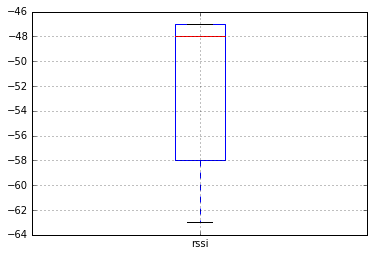

In [95]:
btm0g1 = group1[group1['beacon']==0]
btm0g1.boxplot('rssi')

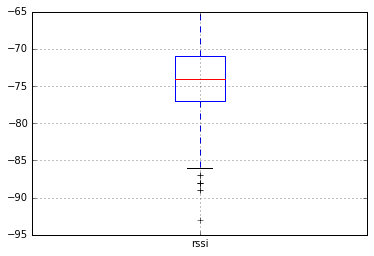

In [96]:
btm0g2 = group2[group2['beacon']==0]
btm0g2.boxplot('rssi')

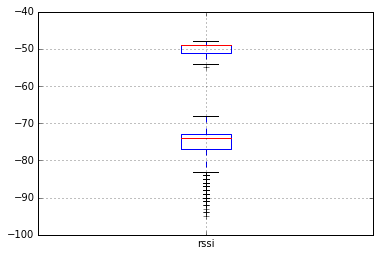

In [106]:
btm1g1 = group1[group1['beacon']==1]
btm1g1.boxplot('rssi')
btm1g2 = group2[group2['beacon']==1]
btm1g2.boxplot('rssi')

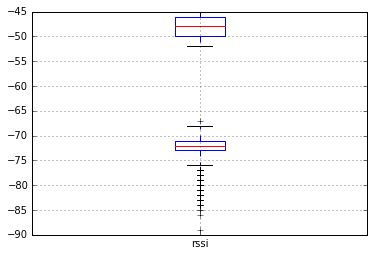

In [108]:
btm2g1 = group1[group1['beacon']==2]
btm2g1.boxplot('rssi')
btm2g2 = group2[group2['beacon']==2]
btm2g2.boxplot('rssi')

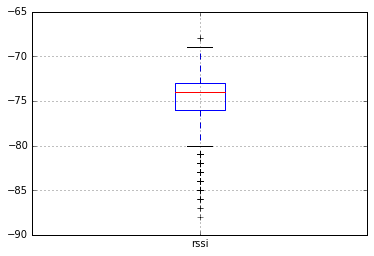

In [100]:
btm3g1 = group1[group1['beacon']==3]
btm3g1.boxplot('rssi')

closet beacons

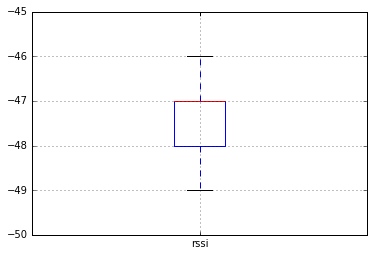

In [101]:
btm3g2 = group2[group2['beacon']==3]
btm3g2.boxplot('rssi')

In [22]:
m4cb = m2b.reset_index().groupby(['datetime', 'member'])['rssi', 'beacon'] \
        .apply(lambda x: x.nlargest(4, columns=['rssi']) \
        .reset_index(drop=True)[['beacon']]).unstack()['beacon'].fillna(-1).astype(int)

# Network Graph

In [14]:
time_slice = slice('2018-03-14 20:00', '2018-03-16 08:00')
m2m_breakout = m2m.loc[time_slice]

m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -60].copy()
m2m_filter_rssi

rssi  rssi_max  \
datetime                  member1    member2                           
2018-03-14 20:00:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.000000     -45.0   
                                     T9UF9VI2OR -51.470588     -51.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -53.933333     -53.0   
                          BEM7P5TBDG HPGHC9MHEG -47.111111     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.200000     -49.0   
2018-03-14 20:01:00-04:00 8HWCSB7F23 D1OQ87MTCX -45.444444     -45.0   
                                     T9UF9VI2OR -51.000000     -48.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -52.818182     -52.0   
                          BEM7P5TBDG HPGHC9MHEG -47.166667     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.000000     -52.0   
2018-03-14 20:02:00-04:00 8HWCSB7F23 D1OQ87MTCX -45.923077     -45.0   
                                     T9UF9VI2OR -51.166667     -50.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -53.588235     -52.0   
                          BEM7P5TBDG HPGHC9MHEG -47.111111     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.600000     -52.0   
2018-03-14 20:03:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.066667     -45.0   
                                     T9UF9VI2OR -50.250000     -50.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -53.500000     -52.0   
                          BEM7P5TBDG HPGHC9MHEG -47.166667     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.416667     -52.0   
2018-03-14 20:04:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.000000     -45.0   
                                     T9UF9VI2OR -51.500000     -51.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -53.933333     -53.0   
                          BEM7P5TBDG HPGHC9MHEG -46.800000     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.000000     -52.0   
...                                                    ...       ...   
2018-03-16 07:56:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.076923     -45.0   
                                     T9UF9VI2OR -50.800000     -48.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -53.923077     -53.0   
                          BEM7P5TBDG HPGHC9MHEG -47.400000     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.571429     -52.0   
2018-03-16 07:57:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.125000     -45.0   
                                     T9UF9VI2OR -50.800000     -50.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -55.066667     -54.0   
                          BEM7P5TBDG HPGHC9MHEG -46.857143     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -53.000000     -53.0   
2018-03-16 07:58:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.076923     -45.0   
                                     T9UF9VI2OR -50.500000     -50.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -54.500000     -54.0   
                          BEM7P5TBDG HPGHC9MHEG -46.750000     -46.0   
                          D1OQ87MTCX T9UF9VI2OR -52.588235     -52.0   
2018-03-16 07:59:00-04:00 8HWCSB7F23 D1OQ87MTCX -46.142857     -45.0   
                                     T9UF9VI2OR -49.066667     -48.0   
                          BDQS73DWHA BEM7P5TBDG -48.000000     -48.0   
                                     HPGHC9MHEG -54.769231     -54.0   
                          BEM7P5TBDG HPGHC9MHEG -46.857143     -46.0   
                      

In [15]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 15]

In [16]:
nx.__version__

'2.2rc1.dev_20180328184857'

In [17]:
# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")

In [18]:
# set colors by region
regions = members_metadata["region"].unique()
len_regions = len(regions)
value_map = {}
for i in range(0,len_regions):
    value_map[regions[i]] = i * (1.0/(len_regions-1))

In [19]:
# Add node information. Assign color
for index, row in members_metadata.iterrows():
    member = row["member"]
    region = row["region"]
    color = value_map.get(region)
    if member in graph.nodes():        
        graph.add_node(member, region=region, color = color)
        
node_colors = [color for member,color in nx.get_node_attributes(graph, 'color').iteritems()]

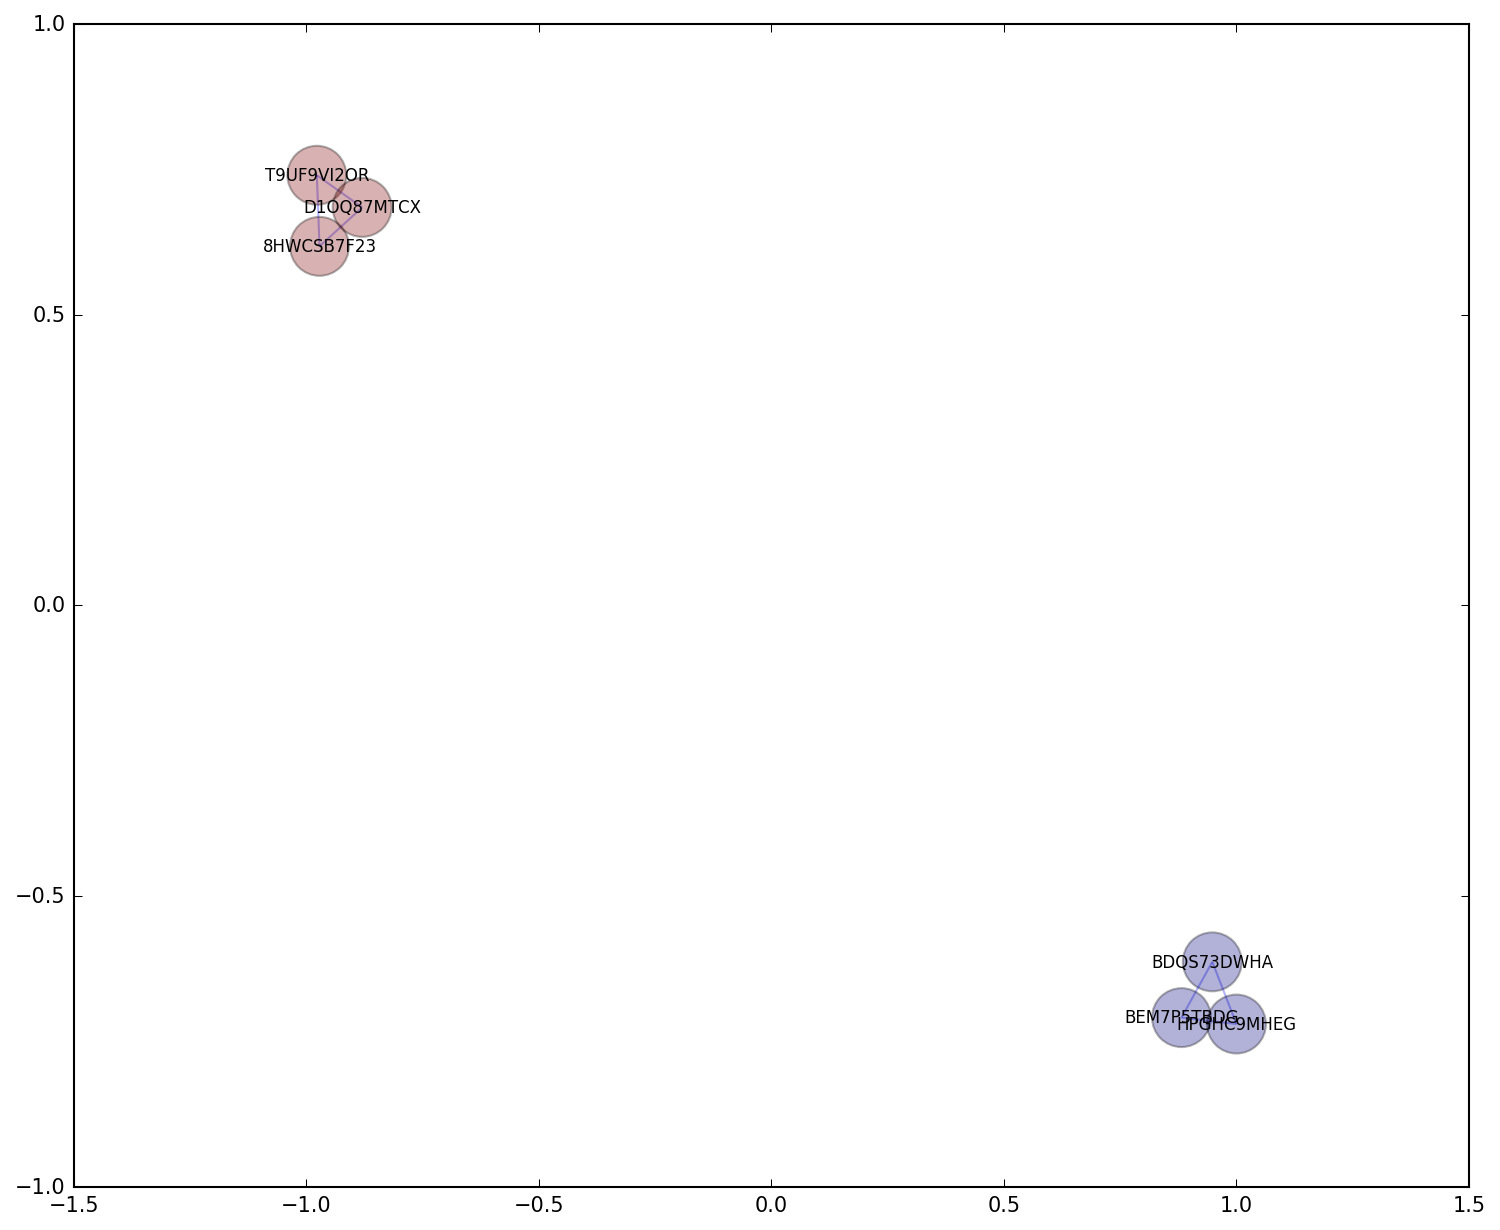

In [20]:
def draw_graph(G, graph_layout='shell',
               node_size=800, node_color='blue', node_alpha=0.3,
               node_text_size=8,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    plt.show()

fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)

draw_graph(graph, graph_layout="spring", node_color = node_colors)